In [1]:
%matplotlib inline
import os
import struct
import torch
import torchvision
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import TensorDataset,DataLoader
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [2]:
TrainImages = torch.load('/media/deepsip/MassStorage/Aupendu/Compression/Color/Data/Fundus/train128_64p.pth')

In [3]:
ValImages = torch.load('/media/deepsip/MassStorage/Aupendu/Compression/Color/Data/Fundus/test128_64p.pth')

In [4]:
TrainImages.size()

torch.Size([24320, 3, 128, 128])

In [5]:
ValImages.size()

torch.Size([1024, 3, 128, 128])

In [6]:
torch.max(TrainImages)

tensor(1.)

In [7]:
torch.max(ValImages)

tensor(1.)

In [8]:
class ClipReLU1(Function):
    
    @staticmethod
    def forward(self, input):
        self.save_for_backward(input)
        return torch.round(4095.0*input.clamp(min=0,max=1))/4095.0
    
    @staticmethod
    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[input > 1] = 0
        return grad_input

In [9]:
class ClipReLU2(Function):
    
    @staticmethod
    def forward(self, input):
        self.save_for_backward(input)
        return torch.round(255.0*input.clamp(min=0,max=1))/255.0
    
    @staticmethod
    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[input > 1] = 0
        return grad_input

In [10]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ELU(), 
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ELU(), 
            
            nn.Conv2d(in_channels=64, out_channels=8, kernel_size=1, stride=1, padding=0))
        
        self.decoder = nn.Sequential(         
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=1, stride=1, padding=0),
            nn.ELU(),

            nn.Conv2d(in_channels=64, out_channels=64*4, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.PixelShuffle(2),
            
            nn.Conv2d(in_channels=64, out_channels=64*4, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.PixelShuffle(2),
            
            nn.Conv2d(in_channels=64, out_channels=64*4, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.PixelShuffle(2),
            
            nn.Conv2d(in_channels=64, out_channels=4*3, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2))

    def forward(self, x):
        x = self.encoder(x)
        x = ClipReLU1.apply(x)
        x = self.decoder(x)
        x = ClipReLU2.apply(x)
        return x

In [11]:
net = autoencoder()
#net = torch.nn.DataParallel(model, device_ids=[0, 1])
net = net.cuda()
TrainImages = TrainImages.cuda()
ValImages = ValImages.cuda()

In [12]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(), lr=1e-4) 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8000,9000], gamma=0.1)

In [13]:
iterations = 10000
BatchSize = 256
BatchSizeV = 256
totalbatch = int(TrainImages.size()[0]/BatchSize)
totalbatchVAL = int(ValImages.size()[0]/BatchSizeV)
TrLoss = []
VLoss = []

epochStart = time.time()
for epoch in range(iterations):
    runningLoss = 0
    scheduler.step()
    for i in range(totalbatch):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long().cuda())
        inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data[0]
    
    if (epoch+1)%10==0:
        LTr = runningLoss/(totalbatch)
        TrLoss.append(LTr)
        runningLoss = 0 
        for i in range(totalbatchVAL):
            inputs = torch.index_select(ValImages,0,torch.linspace(i*BatchSizeV,(i+1)*BatchSizeV - 1,steps=BatchSizeV).long().cuda())
            inputs = Variable(inputs)
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            runningLoss += loss.data[0] 
        VLoss.append(runningLoss/(totalbatchVAL))

        epochEnd = time.time()-epochStart
        epochStart = time.time()
        print('At Iteration: %d / %d  ;  Training Loss: %f ; Val Loss: %f ; Time consumed: %f m %f s '%(epoch + 1,iterations,LTr,runningLoss/(totalbatchVAL),epochEnd//60,epochEnd%60))

/home/deepsip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/deepsip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration: 10 / 10000  ;  Training Loss: 0.003406 ; Val Loss: 0.005000 ; Time consumed: 5.000000 m 13.489309 s 
At Iteration: 20 / 10000  ;  Training Loss: 0.002243 ; Val Loss: 0.003014 ; Time consumed: 5.000000 m 9.057281 s 
At Iteration: 30 / 10000  ;  Training Loss: 0.001281 ; Val Loss: 0.001645 ; Time consumed: 5.000000 m 0.443820 s 
At Iteration: 40 / 10000  ;  Training Loss: 0.000966 ; Val Loss: 0.001298 ; Time consumed: 4.000000 m 9.966255 s 
At Iteration: 50 / 10000  ;  Training Loss: 0.000849 ; Val Loss: 0.001140 ; Time consumed: 5.000000 m 4.833564 s 
At Iteration: 60 / 10000  ;  Training Loss: 0.000887 ; Val Loss: 0.001187 ; Time consumed: 5.000000 m 11.036116 s 
At Iteration: 70 / 10000  ;  Training Loss: 0.000732 ; Val Loss: 0.000932 ; Time consumed: 5.000000 m 11.200586 s 
At Iteration: 80 / 10000  ;  Training Loss: 0.000748 ; Val Loss: 0.000979 ; Time consumed: 5.000000 m 14.841879 s 
At Iteration: 90 / 10000  ;  Training Loss: 0.000671 ; Val Loss: 0.000812 ; Time con

At Iteration: 720 / 10000  ;  Training Loss: 0.000245 ; Val Loss: 0.000394 ; Time consumed: 5.000000 m 33.358475 s 
At Iteration: 730 / 10000  ;  Training Loss: 0.000243 ; Val Loss: 0.000385 ; Time consumed: 5.000000 m 36.572893 s 
At Iteration: 740 / 10000  ;  Training Loss: 0.000239 ; Val Loss: 0.000381 ; Time consumed: 5.000000 m 31.290893 s 
At Iteration: 750 / 10000  ;  Training Loss: 0.000259 ; Val Loss: 0.000398 ; Time consumed: 5.000000 m 30.318877 s 
At Iteration: 760 / 10000  ;  Training Loss: 0.000238 ; Val Loss: 0.000381 ; Time consumed: 5.000000 m 19.319317 s 
At Iteration: 770 / 10000  ;  Training Loss: 0.000252 ; Val Loss: 0.000393 ; Time consumed: 5.000000 m 28.254328 s 
At Iteration: 780 / 10000  ;  Training Loss: 0.000251 ; Val Loss: 0.000384 ; Time consumed: 5.000000 m 30.617298 s 
At Iteration: 790 / 10000  ;  Training Loss: 0.000244 ; Val Loss: 0.000391 ; Time consumed: 5.000000 m 26.723255 s 
At Iteration: 800 / 10000  ;  Training Loss: 0.000247 ; Val Loss: 0.0003

At Iteration: 1430 / 10000  ;  Training Loss: 0.000223 ; Val Loss: 0.000353 ; Time consumed: 4.000000 m 37.023154 s 
At Iteration: 1440 / 10000  ;  Training Loss: 0.000211 ; Val Loss: 0.000354 ; Time consumed: 4.000000 m 35.097806 s 
At Iteration: 1450 / 10000  ;  Training Loss: 0.000214 ; Val Loss: 0.000362 ; Time consumed: 4.000000 m 13.888335 s 
At Iteration: 1460 / 10000  ;  Training Loss: 0.000232 ; Val Loss: 0.000370 ; Time consumed: 4.000000 m 38.533599 s 
At Iteration: 1470 / 10000  ;  Training Loss: 0.000232 ; Val Loss: 0.000373 ; Time consumed: 4.000000 m 41.683636 s 
At Iteration: 1480 / 10000  ;  Training Loss: 0.000222 ; Val Loss: 0.000359 ; Time consumed: 4.000000 m 36.579705 s 
At Iteration: 1490 / 10000  ;  Training Loss: 0.000211 ; Val Loss: 0.000351 ; Time consumed: 4.000000 m 36.146357 s 
At Iteration: 1500 / 10000  ;  Training Loss: 0.000233 ; Val Loss: 0.000374 ; Time consumed: 4.000000 m 33.688975 s 
At Iteration: 1510 / 10000  ;  Training Loss: 0.000256 ; Val Los

At Iteration: 2140 / 10000  ;  Training Loss: 0.000206 ; Val Loss: 0.000348 ; Time consumed: 4.000000 m 6.163364 s 
At Iteration: 2150 / 10000  ;  Training Loss: 0.000204 ; Val Loss: 0.000341 ; Time consumed: 4.000000 m 10.030396 s 
At Iteration: 2160 / 10000  ;  Training Loss: 0.000210 ; Val Loss: 0.000354 ; Time consumed: 4.000000 m 7.781569 s 
At Iteration: 2170 / 10000  ;  Training Loss: 0.000226 ; Val Loss: 0.000369 ; Time consumed: 4.000000 m 2.855173 s 
At Iteration: 2180 / 10000  ;  Training Loss: 0.000200 ; Val Loss: 0.000338 ; Time consumed: 4.000000 m 1.959832 s 
At Iteration: 2190 / 10000  ;  Training Loss: 0.000205 ; Val Loss: 0.000346 ; Time consumed: 4.000000 m 7.705826 s 
At Iteration: 2200 / 10000  ;  Training Loss: 0.000212 ; Val Loss: 0.000348 ; Time consumed: 3.000000 m 12.079466 s 
At Iteration: 2210 / 10000  ;  Training Loss: 0.000204 ; Val Loss: 0.000341 ; Time consumed: 2.000000 m 21.852954 s 
At Iteration: 2220 / 10000  ;  Training Loss: 0.000206 ; Val Loss: 0.

At Iteration: 2850 / 10000  ;  Training Loss: 0.000194 ; Val Loss: 0.000334 ; Time consumed: 2.000000 m 12.379113 s 
At Iteration: 2860 / 10000  ;  Training Loss: 0.000202 ; Val Loss: 0.000337 ; Time consumed: 2.000000 m 8.389224 s 
At Iteration: 2870 / 10000  ;  Training Loss: 0.000194 ; Val Loss: 0.000333 ; Time consumed: 2.000000 m 5.392256 s 
At Iteration: 2880 / 10000  ;  Training Loss: 0.000200 ; Val Loss: 0.000336 ; Time consumed: 2.000000 m 8.182878 s 
At Iteration: 2890 / 10000  ;  Training Loss: 0.000195 ; Val Loss: 0.000332 ; Time consumed: 2.000000 m 9.202363 s 
At Iteration: 2900 / 10000  ;  Training Loss: 0.000197 ; Val Loss: 0.000334 ; Time consumed: 2.000000 m 8.331275 s 
At Iteration: 2910 / 10000  ;  Training Loss: 0.000194 ; Val Loss: 0.000330 ; Time consumed: 2.000000 m 6.411072 s 
At Iteration: 2920 / 10000  ;  Training Loss: 0.000197 ; Val Loss: 0.000335 ; Time consumed: 2.000000 m 3.615296 s 
At Iteration: 2930 / 10000  ;  Training Loss: 0.000193 ; Val Loss: 0.00

At Iteration: 3560 / 10000  ;  Training Loss: 0.000194 ; Val Loss: 0.000333 ; Time consumed: 2.000000 m 11.014997 s 
At Iteration: 3570 / 10000  ;  Training Loss: 0.000192 ; Val Loss: 0.000326 ; Time consumed: 2.000000 m 14.910935 s 
At Iteration: 3580 / 10000  ;  Training Loss: 0.000189 ; Val Loss: 0.000325 ; Time consumed: 2.000000 m 18.167317 s 
At Iteration: 3590 / 10000  ;  Training Loss: 0.000192 ; Val Loss: 0.000331 ; Time consumed: 2.000000 m 16.982390 s 
At Iteration: 3600 / 10000  ;  Training Loss: 0.000197 ; Val Loss: 0.000332 ; Time consumed: 2.000000 m 19.700543 s 
At Iteration: 3610 / 10000  ;  Training Loss: 0.000192 ; Val Loss: 0.000326 ; Time consumed: 2.000000 m 20.802383 s 
At Iteration: 3620 / 10000  ;  Training Loss: 0.000188 ; Val Loss: 0.000323 ; Time consumed: 2.000000 m 20.729629 s 
At Iteration: 3630 / 10000  ;  Training Loss: 0.000191 ; Val Loss: 0.000325 ; Time consumed: 2.000000 m 15.095672 s 
At Iteration: 3640 / 10000  ;  Training Loss: 0.000195 ; Val Los

At Iteration: 4270 / 10000  ;  Training Loss: 0.000185 ; Val Loss: 0.000319 ; Time consumed: 4.000000 m 21.699908 s 
At Iteration: 4280 / 10000  ;  Training Loss: 0.000190 ; Val Loss: 0.000320 ; Time consumed: 4.000000 m 31.023877 s 
At Iteration: 4290 / 10000  ;  Training Loss: 0.000192 ; Val Loss: 0.000326 ; Time consumed: 4.000000 m 30.172743 s 
At Iteration: 4300 / 10000  ;  Training Loss: 0.000189 ; Val Loss: 0.000322 ; Time consumed: 4.000000 m 31.764669 s 
At Iteration: 4310 / 10000  ;  Training Loss: 0.000187 ; Val Loss: 0.000321 ; Time consumed: 4.000000 m 22.035932 s 
At Iteration: 4320 / 10000  ;  Training Loss: 0.000197 ; Val Loss: 0.000321 ; Time consumed: 4.000000 m 31.256419 s 
At Iteration: 4330 / 10000  ;  Training Loss: 0.000186 ; Val Loss: 0.000321 ; Time consumed: 4.000000 m 29.952323 s 
At Iteration: 4340 / 10000  ;  Training Loss: 0.000194 ; Val Loss: 0.000321 ; Time consumed: 4.000000 m 34.794178 s 
At Iteration: 4350 / 10000  ;  Training Loss: 0.000191 ; Val Los

At Iteration: 4980 / 10000  ;  Training Loss: 0.000190 ; Val Loss: 0.000337 ; Time consumed: 4.000000 m 35.543184 s 
At Iteration: 4990 / 10000  ;  Training Loss: 0.000185 ; Val Loss: 0.000318 ; Time consumed: 4.000000 m 27.817765 s 
At Iteration: 5000 / 10000  ;  Training Loss: 0.000188 ; Val Loss: 0.000323 ; Time consumed: 4.000000 m 32.856733 s 
At Iteration: 5010 / 10000  ;  Training Loss: 0.000184 ; Val Loss: 0.000317 ; Time consumed: 4.000000 m 36.314214 s 
At Iteration: 5020 / 10000  ;  Training Loss: 0.000188 ; Val Loss: 0.000320 ; Time consumed: 4.000000 m 31.634133 s 
At Iteration: 5030 / 10000  ;  Training Loss: 0.000184 ; Val Loss: 0.000316 ; Time consumed: 4.000000 m 11.230978 s 
At Iteration: 5040 / 10000  ;  Training Loss: 0.000183 ; Val Loss: 0.000317 ; Time consumed: 4.000000 m 36.353038 s 
At Iteration: 5050 / 10000  ;  Training Loss: 0.000186 ; Val Loss: 0.000317 ; Time consumed: 4.000000 m 33.592996 s 
At Iteration: 5060 / 10000  ;  Training Loss: 0.000193 ; Val Los

At Iteration: 5690 / 10000  ;  Training Loss: 0.000185 ; Val Loss: 0.000316 ; Time consumed: 4.000000 m 34.462560 s 
At Iteration: 5700 / 10000  ;  Training Loss: 0.000181 ; Val Loss: 0.000314 ; Time consumed: 4.000000 m 31.368556 s 
At Iteration: 5710 / 10000  ;  Training Loss: 0.000190 ; Val Loss: 0.000330 ; Time consumed: 4.000000 m 33.244766 s 
At Iteration: 5720 / 10000  ;  Training Loss: 0.000182 ; Val Loss: 0.000315 ; Time consumed: 4.000000 m 33.064952 s 
At Iteration: 5730 / 10000  ;  Training Loss: 0.000187 ; Val Loss: 0.000315 ; Time consumed: 4.000000 m 37.831300 s 
At Iteration: 5740 / 10000  ;  Training Loss: 0.000192 ; Val Loss: 0.000322 ; Time consumed: 4.000000 m 37.541885 s 
At Iteration: 5750 / 10000  ;  Training Loss: 0.000182 ; Val Loss: 0.000314 ; Time consumed: 4.000000 m 40.686068 s 
At Iteration: 5760 / 10000  ;  Training Loss: 0.000190 ; Val Loss: 0.000325 ; Time consumed: 4.000000 m 26.422534 s 
At Iteration: 5770 / 10000  ;  Training Loss: 0.000181 ; Val Los

At Iteration: 6400 / 10000  ;  Training Loss: 0.000180 ; Val Loss: 0.000310 ; Time consumed: 4.000000 m 23.122749 s 
At Iteration: 6410 / 10000  ;  Training Loss: 0.000183 ; Val Loss: 0.000317 ; Time consumed: 4.000000 m 23.261033 s 
At Iteration: 6420 / 10000  ;  Training Loss: 0.000183 ; Val Loss: 0.000314 ; Time consumed: 4.000000 m 22.668223 s 
At Iteration: 6430 / 10000  ;  Training Loss: 0.000188 ; Val Loss: 0.000316 ; Time consumed: 4.000000 m 20.814198 s 
At Iteration: 6440 / 10000  ;  Training Loss: 0.000183 ; Val Loss: 0.000312 ; Time consumed: 4.000000 m 24.892787 s 
At Iteration: 6450 / 10000  ;  Training Loss: 0.000181 ; Val Loss: 0.000312 ; Time consumed: 4.000000 m 21.363684 s 
At Iteration: 6460 / 10000  ;  Training Loss: 0.000179 ; Val Loss: 0.000310 ; Time consumed: 4.000000 m 24.801715 s 
At Iteration: 6470 / 10000  ;  Training Loss: 0.000204 ; Val Loss: 0.000323 ; Time consumed: 4.000000 m 29.598959 s 
At Iteration: 6480 / 10000  ;  Training Loss: 0.000186 ; Val Los

At Iteration: 7110 / 10000  ;  Training Loss: 0.000180 ; Val Loss: 0.000310 ; Time consumed: 4.000000 m 50.581499 s 
At Iteration: 7120 / 10000  ;  Training Loss: 0.000194 ; Val Loss: 0.000312 ; Time consumed: 4.000000 m 51.412220 s 
At Iteration: 7130 / 10000  ;  Training Loss: 0.000180 ; Val Loss: 0.000314 ; Time consumed: 4.000000 m 48.304288 s 
At Iteration: 7140 / 10000  ;  Training Loss: 0.000178 ; Val Loss: 0.000308 ; Time consumed: 4.000000 m 48.656464 s 
At Iteration: 7150 / 10000  ;  Training Loss: 0.000178 ; Val Loss: 0.000309 ; Time consumed: 4.000000 m 48.775648 s 
At Iteration: 7160 / 10000  ;  Training Loss: 0.000182 ; Val Loss: 0.000313 ; Time consumed: 4.000000 m 51.795691 s 
At Iteration: 7170 / 10000  ;  Training Loss: 0.000178 ; Val Loss: 0.000308 ; Time consumed: 4.000000 m 51.720762 s 
At Iteration: 7180 / 10000  ;  Training Loss: 0.000179 ; Val Loss: 0.000313 ; Time consumed: 4.000000 m 54.756242 s 
At Iteration: 7190 / 10000  ;  Training Loss: 0.000184 ; Val Los

At Iteration: 7820 / 10000  ;  Training Loss: 0.000182 ; Val Loss: 0.000317 ; Time consumed: 2.000000 m 45.624076 s 
At Iteration: 7830 / 10000  ;  Training Loss: 0.000178 ; Val Loss: 0.000308 ; Time consumed: 2.000000 m 38.142920 s 
At Iteration: 7840 / 10000  ;  Training Loss: 0.000179 ; Val Loss: 0.000309 ; Time consumed: 2.000000 m 47.496858 s 
At Iteration: 7850 / 10000  ;  Training Loss: 0.000177 ; Val Loss: 0.000307 ; Time consumed: 2.000000 m 48.623982 s 
At Iteration: 7860 / 10000  ;  Training Loss: 0.000178 ; Val Loss: 0.000308 ; Time consumed: 2.000000 m 48.235526 s 
At Iteration: 7870 / 10000  ;  Training Loss: 0.000179 ; Val Loss: 0.000310 ; Time consumed: 2.000000 m 48.784829 s 
At Iteration: 7880 / 10000  ;  Training Loss: 0.000177 ; Val Loss: 0.000307 ; Time consumed: 2.000000 m 46.821305 s 
At Iteration: 7890 / 10000  ;  Training Loss: 0.000180 ; Val Loss: 0.000315 ; Time consumed: 2.000000 m 46.636457 s 
At Iteration: 7900 / 10000  ;  Training Loss: 0.000177 ; Val Los

At Iteration: 8530 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 47.489867 s 
At Iteration: 8540 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 47.948043 s 
At Iteration: 8550 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 47.556377 s 
At Iteration: 8560 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 44.492225 s 
At Iteration: 8570 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 34.776826 s 
At Iteration: 8580 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 49.147396 s 
At Iteration: 8590 / 10000  ;  Training Loss: 0.000174 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 50.126696 s 
At Iteration: 8600 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000304 ; Time consumed: 2.000000 m 50.422371 s 
At Iteration: 8610 / 10000  ;  Training Loss: 0.000173 ; Val Los

At Iteration: 9240 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 19.657339 s 
At Iteration: 9250 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 22.317090 s 
At Iteration: 9260 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 22.636319 s 
At Iteration: 9270 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 22.116455 s 
At Iteration: 9280 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 21.849383 s 
At Iteration: 9290 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 23.341310 s 
At Iteration: 9300 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 24.601829 s 
At Iteration: 9310 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 2.000000 m 22.954924 s 
At Iteration: 9320 / 10000  ;  Training Loss: 0.000173 ; Val Los

At Iteration: 9950 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 4.000000 m 12.822741 s 
At Iteration: 9960 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 4.000000 m 11.480549 s 
At Iteration: 9970 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 4.000000 m 12.682557 s 
At Iteration: 9980 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 4.000000 m 15.897679 s 
At Iteration: 9990 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 4.000000 m 8.974126 s 
At Iteration: 10000 / 10000  ;  Training Loss: 0.000173 ; Val Loss: 0.000303 ; Time consumed: 4.000000 m 6.324522 s 


In [14]:
torch.save(net.cpu(), 'TrainFundus1.pt')

/home/deepsip/anaconda3/lib/python3.6/site-packages/torch/serialization.py:196: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
torch.save(TrLoss, '/media/deepsip/MassStorage/Aupendu/Compression/Color/Curve/TrLoss1_Fundus.pt')
torch.save(VLoss, '/media/deepsip/MassStorage/Aupendu/Compression/Color/Curve/VlLoss1_Fundus.pt')

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imgfile = np.array(Image.open('/media/deepsip/MassStorage/Aupendu/Compression/Color/Data/Fundus/test/im0005.ppm'))
imgfile = torch.unsqueeze(torch.from_numpy(np.transpose(imgfile.astype(float), (2,0,1))).float(),0)
imgfile = imgfile/255.0
output = net(Variable(imgfile))

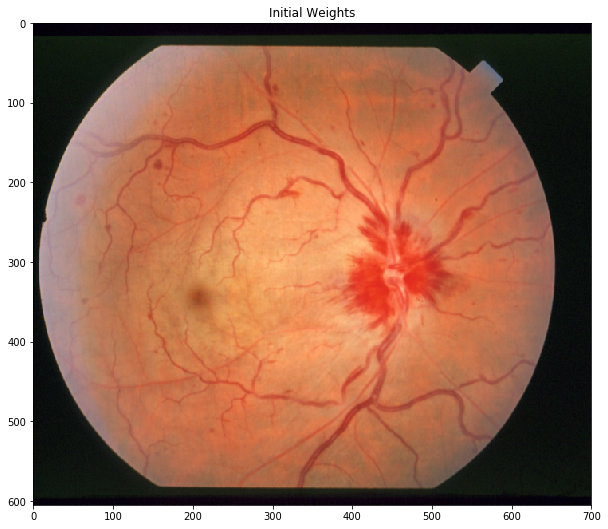

In [17]:
imshow(torchvision.utils.make_grid(imgfile,nrow=1),'Initial Weights')

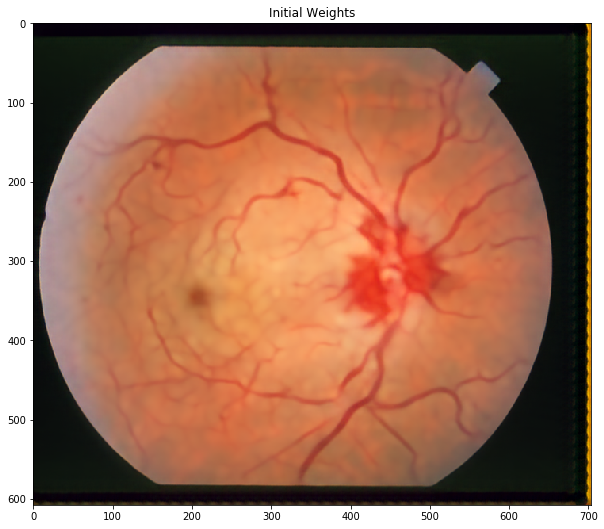

In [18]:
imshow(torchvision.utils.make_grid(output.data,nrow=1),'Initial Weights')